# Generation and distribution
1. Simplified generation based on population and jobs
3. Doubly constrained distribution
    - based on zone-to-zone distance
    - based on a given deterrence matrix

In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel

import numpy as np
import pandas as pd
from quetzal.io import display

C:\Users\rgoix\AppData\Local\Continuum\anaconda3\envs\quetzal_env\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'

Load quetzal model `{scenario}/aon_pathfinder.zip`.

Explore `sm.zones` GeoDataFrame.

# Generation
- Production = Population
- Attraction = Jobs

In [6]:
sm.zones['emission'] =  sm.zones['pop'].astype(int) / 10 # peak hour generation
sm.zones['attraction'] =  sm.zones['emp'].astype(int) / 10

In [7]:
sm.zones['emission'].sum()

215818.30000000005

In [8]:
sm.zones['attraction'].sum()

164266.2

# Distribution

## Test - default distribution

In [9]:
sm_default = sm.copy()

Default

In [10]:
sm_default.step_distribution(power=2)

1. Analyze the distribution of volumes with respect to zone to zone distance using an histogram plot.
2. Run the distribution step with different values for `power` and analyze.

For 1. you can obtain the zone to zone euclidean distance matrix with:  
```
from syspy.skims import skims
euclidean = skims.euclidean(sm_default.zones, coordinates_unit=sm_default.coordinates_unit)
```

With a deterrence matrix  
1. copy euclidean dataframe into deterrence dataframe
2. create a `'deterrence'` column equals to `1/euclidean_distance**2`
3. Plot deterrence versus distance (scatter plot)

In [15]:
deterrence = deterrence.set_index(['origin', 'destination'])['deterrence'].unstack()

In [16]:
sm_default.step_distribution(deterrence_matrix=deterrence)

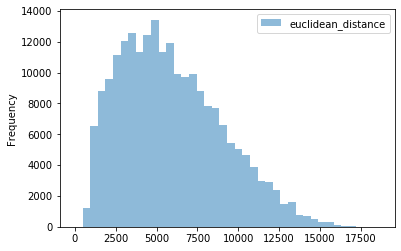

In [17]:
od = pd.merge(sm_default.volumes, euclidean, on=['origin', 'destination'])
import matplotlib.pyplot as plt
od[['euclidean_distance']].plot(kind='hist', weights=od['volume'], bins=40, alpha=0.5)

## car owners
car owners distribution is based on car times

In [18]:
motor_rate = 0.3
car = sm.copy()
car.zones['emission'] *= motor_rate

Create a deterrence matrix based on zone to zone car duration

In [20]:
car.step_distribution(deterrence_matrix=deterrence_matrix)

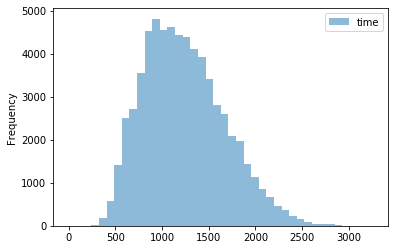

In [21]:
od = pd.merge(car.volumes, car.car_los, on=['origin', 'destination'])
import matplotlib.pyplot as plt
od[['time']].plot(kind='hist', weights=od['volume'], bins=40, alpha=0.5)

# PT captives
Non-car owners distribution is based on pt times

In [22]:
pt = sm.copy()
pt.zones['emission'] *= (1-motor_rate)

1. Create a deterrence matrix based on zone to zone PT duration
2. Apply the distribution step with this matrix
3. analyze with an histogram plot

# merge matrices

In [26]:
sm.volumes = pd.merge(
    car.volumes,
    pt.volumes,
    on=['origin', 'destination'],
    suffixes=[ '_car_owner', '_pt_captive']
).rename(columns={'volume_car_owner': 'car_owner', 'volume_pt_captive': 'pt_captive'})

# to_zip

In [27]:
sm.to_zip(
    training_folder + 'model/{scen}/distribution.zip'.format(scen=scenario), 
    only_attributes=['volumes', 'epsg', 'coordinates_unit']
)

to_hdf(new file): 100%|███████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 211.63it/s]


# monitoring

Text(0.5, 1.0, 'car owners distribution')

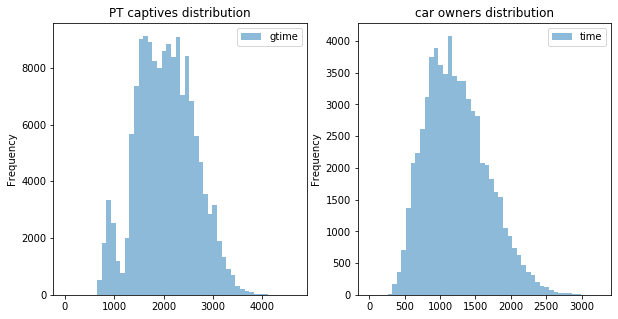

In [29]:
od = pd.merge(sm.volumes, sm.pt_los, on=['origin', 'destination'])
od = pd.merge(od, sm.car_los, on=['origin', 'destination'])

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=[10, 5])
plot = od[['gtime']].plot(kind='hist', weights=od['pt_captive'], bins=50, alpha=0.5, ax=axes[0])
plot.set_title('PT captives distribution')

plot = od[['time']].plot(kind='hist', weights=od['car_owner'], bins=50, alpha=0.5, ax=axes[1])
plot.set_title('car owners distribution')

# END